In [1]:
!pip install transformers torch torchvision accelerate bitsandbytes datasets pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 24.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled n

In [2]:
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.1/512.1 kB 8.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 62.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: hf-xet
    Found existing installation: hf-xet 1.1.0
    Uninstalling hf-xet-1.1.0:
      Successfully uninstalled hf-xet-1.1.0
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.31.1
    Uninstalling huggingface-hub-0.31.1:
      Successfully uninstalled huggingface-hub-0.31.1


In [3]:
import os
import pandas as pd

# Base path to dataset
base_path = "/kaggle/input/flickr8kimagescaptions"




# Load and preprocess captions
df=  pd.read_csv("/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt")
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
import os
import pandas as pd

# ✅ Base dataset path
base_path = "/kaggle/input/flickr8kimagescaptions/flickr8k"

# ✅ Paths to images and captions
image_dir = os.path.join(base_path, "images")               # Folder containing all image files
captions_file = os.path.join(base_path, "captions.txt")     # File with captions

# ✅ Load captions
df = pd.read_csv(captions_file)
df.dropna(inplace=True)  # Drop rows with missing captions if any

# ✅ Add full image path column
df["image_path"] = df["image"].apply(lambda x: os.path.join(image_dir, x))

# ✅ Preview
print("Total samples:", len(df))
print(df.head())


Total samples: 40455
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  \
0  A child in a pink dress is climbing up a set o...   
1              A girl going into a wooden building .   
2   A little girl climbing into a wooden playhouse .   
3  A little girl climbing the stairs to her playh...   
4  A little girl in a pink dress going into a woo...   

                                          image_path  
0  /kaggle/input/flickr8kimagescaptions/flickr8k/...  
1  /kaggle/input/flickr8kimagescaptions/flickr8k/...  
2  /kaggle/input/flickr8kimagescaptions/flickr8k/...  
3  /kaggle/input/flickr8kimagescaptions/flickr8k/...  
4  /kaggle/input/flickr8kimagescaptions/flickr8k/...  


In [5]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTModel
from transformers import LlamaTokenizer, LlamaForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

2025-06-04 18:36:57.921853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749062218.137874      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749062218.192713      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [6]:
from sklearn.model_selection import train_test_split

# Assuming train_df is your original dataset
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
print("Total samples:", len(train_df))
print(train_df.head())

Total samples: 32364
                           image  \
32121   359082432_c1fd5aa2d6.jpg   
9831   2460799229_ce45a1d940.jpg   
33128  3634828052_3b6aeda7d6.jpg   
6199   2216568822_84c295c3b0.jpg   
19661  3080056515_3013830309.jpg   

                                                 caption  \
32121  A man and a dog are standing on a tree that ha...   
9831   The three boys who are wearing life jackets ar...   
33128  A woman with a camera with a very long lens ta...   
6199   Woman with red crash helmet and Native America...   
19661              One person is whispering to another .   

                                              image_path  
32121  /kaggle/input/flickr8kimagescaptions/flickr8k/...  
9831   /kaggle/input/flickr8kimagescaptions/flickr8k/...  
33128  /kaggle/input/flickr8kimagescaptions/flickr8k/...  
6199   /kaggle/input/flickr8kimagescaptions/flickr8k/...  
19661  /kaggle/input/flickr8kimagescaptions/flickr8k/...  


In [8]:
print("Total samples:", len(val_df))
print(val_df.head())

Total samples: 8091
                           image  \
17775  2973269132_252bfd0160.jpg   
13506   270263570_3160f360d3.jpg   
4325   2053006423_6adf69ca67.jpg   
37870   512101751_05a6d93e19.jpg   
21321  3156406419_38fbd52007.jpg   

                                                 caption  \
17775  A large wild cat is pursuing a horse across a ...   
13506         Two brown dogs fight on the leafy ground .   
4325   A man in shorts is standing on a rock looking ...   
37870      a muzzled white dog is running on the grass .   
21321                         A person skiing downhill .   

                                              image_path  
17775  /kaggle/input/flickr8kimagescaptions/flickr8k/...  
13506  /kaggle/input/flickr8kimagescaptions/flickr8k/...  
4325   /kaggle/input/flickr8kimagescaptions/flickr8k/...  
37870  /kaggle/input/flickr8kimagescaptions/flickr8k/...  
21321  /kaggle/input/flickr8kimagescaptions/flickr8k/...  


In [9]:


def create_dataframe(dff):
    data = []
    i = 0
    for _, item in dff.iterrows():
        i += 1
        print(i, '\n')
        image = item['image_path']  # Load and convert image
        row = {
            'image_path': image,
            'caption': item['caption']
        }
        data.append(row)
    return pd.DataFrame(data)

train_df = create_dataframe(train_df)
val_df = create_dataframe(val_df)


1 

2 

3 

4 

5 

6 

7 

8 

9 

10 

11 

12 

13 

14 

15 

16 

17 

18 

19 

20 

21 

22 

23 

24 

25 

26 

27 

28 

29 

30 

31 

32 

33 

34 

35 

36 

37 

38 

39 

40 

41 

42 

43 

44 

45 

46 

47 

48 

49 

50 

51 

52 

53 

54 

55 

56 

57 

58 

59 

60 

61 

62 

63 

64 

65 

66 

67 

68 

69 

70 

71 

72 

73 

74 

75 

76 

77 

78 

79 

80 

81 

82 

83 

84 

85 

86 

87 

88 

89 

90 

91 

92 

93 

94 

95 

96 

97 

98 

99 

100 

101 

102 

103 

104 

105 

106 

107 

108 

109 

110 

111 

112 

113 

114 

115 

116 

117 

118 

119 

120 

121 

122 

123 

124 

125 

126 

127 

128 

129 

130 

131 

132 

133 

134 

135 

136 

137 

138 

139 

140 

141 

142 

143 

144 

145 

146 

147 

148 

149 

150 

151 

152 

153 

154 

155 

156 

157 

158 

159 

160 

161 

162 

163 

164 

165 

166 

167 

168 

169 

170 

171 

172 

173 

174 

175 

176 

177 

178 

179 

180 

181 

182 

183 

184 

185 

In [10]:
train_df.shape

(32364, 2)

In [11]:
val_df.shape

(8091, 2)

In [12]:
class Flickr8kDataset(Dataset):
    def __init__(self, df, feature_extractor, tokenizer, max_length=128):
        self.df = df
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image and caption
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        caption = row['caption']  # Access 'caption' directly

        # Process image
        image_features = self.feature_extractor(image, return_tensors="pt")
        '''
        Applies the feature extractor to the image (e.g., resizing, normalization).
        return -{'pixel_values': tensor of shape [1, 3, H, W]}

        '''

        # Process text
        tokenized_caption = self.tokenizer(
            caption,
            padding='max_length',
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )# return -{'input_ids': tensor of shape [1, max_length]}


        return {
            'pixel_values': image_features['pixel_values'].squeeze(),# For image encoder (ViT)
            'labels': tokenized_caption['input_ids'].squeeze()# For text decoder (LLaMA)
        }

In [13]:
def train_one_epoch(model, dataloader, optimizer, device):
    '''
    model: a VisionEncoderDecoderModel (ViT + TinyLlama)

dataloader: batches of {pixel_values, labels}

optimizer: e.g., AdamW

device: "cuda" or "cpu"


    '''
    model.train()#Puts model in training mode (enables dropout, etc.).
    total_loss = 0#total_loss accumulates batch losses for average.
    progress_bar = tqdm(dataloader, desc="Training", leave=True)#tqdm(...) adds a real-time progress bar during training.

    for batch in progress_bar:
        # Move batch to device
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        '''
        pixel_values: Image tensor from ViT processor.

        labels: Token IDs from tokenizer (target caption).

        Both are moved to GPU (or CPU).
        '''

        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()# Clear gradients
        loss.backward()# Backpropagation
        optimizer.step()# Update weights

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})#loss.item() converts the tensor to a Python float.The loss is shown in the progress bar live.

    return total_loss / len(dataloader)#Returns average loss per batch for the entire epoch.


In [21]:
import torch
from transformers import (
    ViTModel,
    GPT2LMHeadModel,
    GPT2Config,
    AutoTokenizer,
    VisionEncoderDecoderModel,
    ViTImageProcessor
)
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# Define model names
ENCODER = "google/vit-base-patch16-224"
DECODER = "gpt2"


# Load encoder
encoder = ViTModel.from_pretrained(ENCODER)

# Load GPT2 config with cross-attention enabled
decoder_config = GPT2Config.from_pretrained(DECODER)
decoder_config.add_cross_attention = True  # <--- Critical line
decoder = GPT2LMHeadModel.from_pretrained(DECODER, config=decoder_config)

# Combine encoder and decoder
model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder).to(device)

# Load tokenizer and feature extractor
feature_extractor = ViTImageProcessor.from_pretrained(ENCODER)
tokenizer = AutoTokenizer.from_pretrained(DECODER)
tokenizer.pad_token = tokenizer.eos_token  # GPT2 has no pad token

# Configure model tokens
model.config.pad_token_id = tokenizer.pad_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.vocab_size = model.decoder.config.vocab_size

# Define collate function
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = [item["labels"] for item in batch]
    labels = pad_sequence(labels, batch_first=True, padding_value=tokenizer.pad_token_id)
    return {
        "pixel_values": pixel_values,
        "labels": labels
    }

# Create dataset and dataloader (assuming Flickr8kDataset is defined)
train_dataset = Flickr8kDataset(train_df, feature_extractor, tokenizer)
val_dataset = Flickr8kDataset(val_df, feature_extractor, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
print('done')




Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'tran

done


In [22]:
!pip install nltk
from nltk.translate.bleu_score import corpus_bleu

def evaluate(model, dataloader, tokenizer, device):
    model.eval()  # Disables gradient calculation (saves memory and computation during evaluation)
    all_predictions = []
    all_references = []

    # Set pad_token if missing (important for GPT-like decoders)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move image features to device
            pixel_values = batch['pixel_values'].to(device)

            # Generate caption predictions
            outputs = model.generate(
                pixel_values=pixel_values,
                max_length=128,
                num_beams=4,
                early_stopping=True,
                pad_token_id=tokenizer.pad_token_id,  # Important!
                attention_mask=torch.ones(pixel_values.shape[:2], dtype=torch.long).to(device)  # trick to avoid warning
            )

            # Decode predictions and references into text
            predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            references = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

            # Convert text to token lists for BLEU
            all_predictions.extend([pred.split() for pred in predictions])
            all_references.extend([[ref.split()] for ref in references])  # Nested for NLTK compatibility

    # Compute BLEU scores from n-gram 1 to 4
    bleu_scores = {}
    for n in range(1, 5):
        weights = tuple((1/n,) * n)
        bleu_scores[f'bleu-{n}'] = corpus_bleu(
            all_references,
            all_predictions,
            weights=weights
        )

    return bleu_scores


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:




print("Starting training...")
train_loss = train_one_epoch(model, train_dataloader, optimizer, device)
print(f"Training loss: {train_loss:.4f}")

# Evaluation
print("Evaluating...")
bleu_scores = evaluate(model, val_dataloader, tokenizer, device)
for metric, score in bleu_scores.items():
    print(f"{metric}: {score:.4f}")

model.save_pretrained("fine_tuned_image_captioning")
tokenizer.save_pretrained("fine_tuned_image_captioning")
feature_extractor.save_pretrained("fine_tuned_image_captioning")

Starting training...


Training: 100%|██████████| 2023/2023 [28:23<00:00,  1.19it/s, loss=0.3243]


Training loss: 0.4088
Evaluating...


Evaluating: 100%|██████████| 506/506 [20:42<00:00,  2.46s/it]
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


bleu-1: 0.1915
bleu-2: 0.0305
bleu-3: 0.0041
bleu-4: 0.0000


['fine_tuned_image_captioning/preprocessor_config.json']

In [27]:
import matplotlib.pyplot as plt



Generated Caption:  man a wearing hat a hat sunglasses


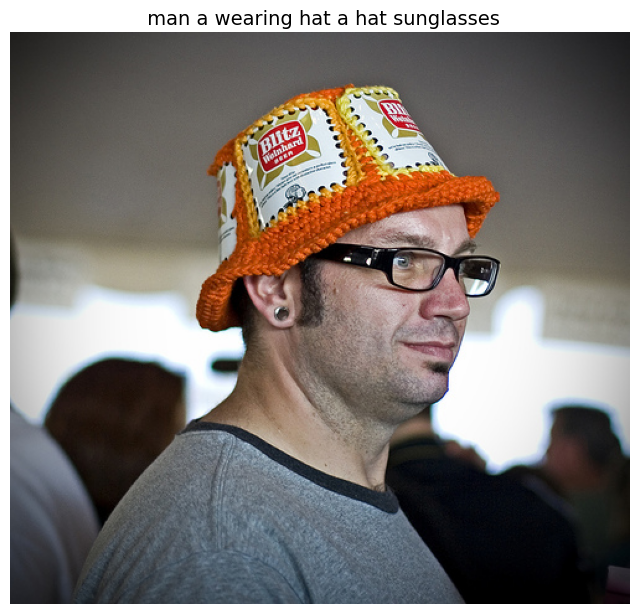

In [32]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, ViTImageProcessor
from PIL import Image
import torch
import matplotlib.pyplot as plt

class ImageCaptioning:
    def __init__(self, model_dir="fine_tuned_image_captioning"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = VisionEncoderDecoderModel.from_pretrained(model_dir).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_dir)
        self.processor = ViTImageProcessor.from_pretrained(model_dir)

    def caption_image(self, image_path, max_length=128, num_beams=4):
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.to(self.device)

        output_ids =  model.generate(
                pixel_values=pixel_values,
                max_length=128,
                num_beams=4,
                early_stopping=True,
                pad_token_id=tokenizer.pad_token_id,  # Important!
                attention_mask=torch.ones(pixel_values.shape[:2], dtype=torch.long).to(device)  # trick to avoid warning
            )

        caption = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return caption, image

# Instantiate the captioner
captioner = ImageCaptioning("/kaggle/working/fine_tuned_image_captioning")

# Get caption and image
caption, image = captioner.caption_image("/kaggle/input/flickr8kimagescaptions/flickr8k/images/1007129816_e794419615.jpg")

# Print and display
print("Generated Caption:", caption)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.title(caption, fontsize=14)
plt.show()


Generated Captions:
1.  black white running a with tennis in mouth
2.  black white white running the with tennis in mouth
3.  black white white running a with tennis in mouth
4.  black white running a with tennis .
5.  black white running a with ball its .


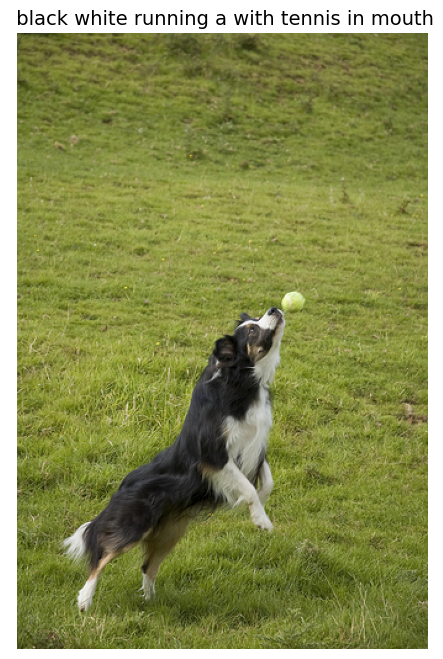

In [47]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, ViTImageProcessor
from PIL import Image
import torch
import matplotlib.pyplot as plt

from transformers import VisionEncoderDecoderModel, AutoTokenizer, ViTImageProcessor
from PIL import Image
import torch
import matplotlib.pyplot as plt

class ImageCaptioning:
    def __init__(self, model_dir="/kaggle/working/fine_tuned_image_captioning"):
        # Set device (GPU if available)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load model and supporting components
        self.model = VisionEncoderDecoderModel.from_pretrained(model_dir).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_dir)
        self.processor = ViTImageProcessor.from_pretrained(model_dir)

        # Set pad token if missing (important for generation)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def caption_image(self, image_path, max_length=300, num_beams=5, num_return_sequences=5):
        """
        Generate captions for a given image.
        """
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.to(self.device)

        # Generate captions
        output_ids = self.model.generate(
    pixel_values=pixel_values,
    max_length=max_length,
    num_beams=num_beams,
    num_return_sequences=num_return_sequences,
    early_stopping=True,
    pad_token_id=self.tokenizer.pad_token_id,
    attention_mask=torch.ones(pixel_values.shape[:2], dtype=torch.long).to(self.device),
    repetition_penalty=1.2,      # reduce repeated words
    length_penalty=0.9,          # encourage shorter sentences if needed
    temperature=1.0              # add diversity in generation
)


        # Decode all captions to strings
        captions = self.tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        return captions, image

    def display_image_with_captions(self, image_path, max_length=128, num_beams=4, num_return_sequences=5):
        """
        Generate captions and display the image with the first caption.
        Also prints all generated captions.
        """
        captions, image = self.caption_image(image_path, max_length, num_beams, num_return_sequences)

        # Print all captions
        print("Generated Captions:")
        for i, cap in enumerate(captions, 1):
            print(f"{i}. {cap}")

        # Display image with first caption as title
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.axis("off")
        plt.title(captions[0], fontsize=14)
        plt.show()


# Instantiate the captioner with your fine-tuned model directory
captioner = ImageCaptioning()

# Call display_image_with_captions with valid parameters
captioner.display_image_with_captions(
    "/kaggle/input/flickr8kimagescaptions/flickr8k/images/1072153132_53d2bb1b60.jpg",
    max_length=128,
    num_beams=5,           # number of beams for beam search
    num_return_sequences=5 # must be <= num_beams
)


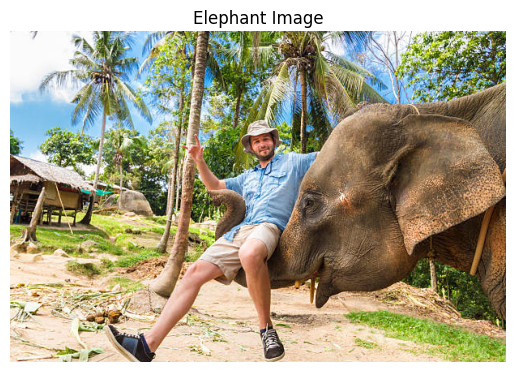

In [36]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Image URL
url = "https://media.istockphoto.com/id/515660887/photo/elephan-lifting-a-tourist.jpg?s=612x612&w=0&k=20&c=fYY_5u9zdFc3rXAjzEG9Ha7l_Sve6HY2kaUZUDcy53U="

# Download image
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")

# Save it to a file
image.save("elephant.jpg")  # Now you can use this path for captioning

# Display it
plt.imshow(image)
plt.axis("off")
plt.title("Elephant Image")
plt.show()


Generated Captions:
1.  man a wearing shirt a shirt a is a .
2.  man a wearing shirt a shirt a is a on .
3.  man a wearing shirt a shirt a is on rock
4.  man a wearing shirt a shirt a is a on rock
5.  man a wearing shirt a is a on rock


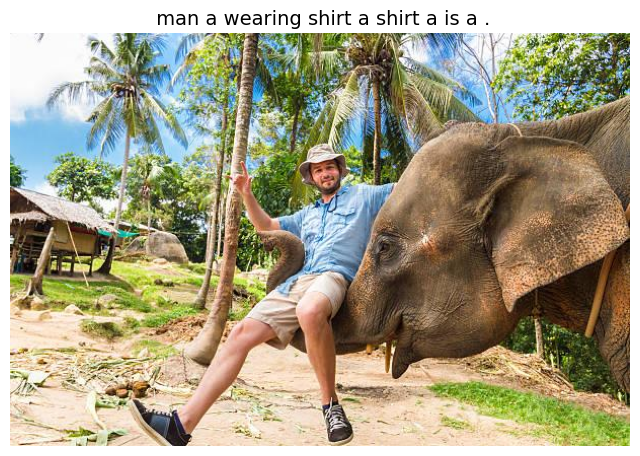

In [50]:
captioner = ImageCaptioning()

# Call display_image_with_captions with valid parameters
captioner.display_image_with_captions(
    "/kaggle/working/elephant.jpg",
    max_length=128,
    num_beams=5,           # number of beams for beam search
    num_return_sequences=5 # must be <= num_beams
)

In [51]:
import shutil

# This will create fine_tuned_image_captioning.zip in /kaggle/working/
shutil.make_archive("/kaggle/working/fine_tuned_image_captioning", 'zip', "/kaggle/working/fine_tuned_image_captioning")


'/kaggle/working/fine_tuned_image_captioning.zip'